In [1]:
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np
import datetime as DT
#from sklearn.experimental import enable_iterative_imputer
#from sklearn.impute import IterativeImputer
#from sklearn.impute import SimpleImputer
from fancyimpute import KNN
from sklearn.preprocessing import OrdinalEncoder
import copy

In [2]:
trans = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name = 'Transactions')

new_cust = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name = 'NewCustomerList')

cust_demo = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name = 'CustomerDemographic')

cust_address = pd.read_excel('KPMG_VI_New_raw_data_update_final.xlsx',sheet_name = 'CustomerAddress')

In [3]:
print("Transaction shape:={}".format(trans.shape))
print("NewCustomerList shape:={}".format(new_cust.shape))
print("CustomerDemographic shape:={}".format(cust_demo.shape))
print("CustomerAddress shape:={}".format(cust_address.shape))

Transaction shape:=(20000, 13)
NewCustomerList shape:=(1000, 23)
CustomerDemographic shape:=(4000, 13)
CustomerAddress shape:=(3999, 6)


In [4]:
#############################################################
# Data cleaning
# CD
# Remove the rows with missing DOB
cust_demo_dc = cust_demo[cust_demo.DOB.notnull()]
do = {'Yes':True,'No':False}
cust_demo_dc.owns_car = cust_demo_dc.owns_car.map(do)
dg = {'F': 'F','M':'M','Female':'F',"Male":'M','Femal':'F','U':None}
cust_demo_dc.gender =cust_demo_dc.gender.map(dg)
cust_demo_dc.info()
dd = {'N':False,'Y':True}
cust_demo_dc.deceased_indicator = cust_demo_dc.deceased_indicator.map(dd)
cust_demo_dc = cust_demo_dc[cust_demo_dc.DOB != '1843-12-21']
now = pd.Timestamp('now')
cust_demo_dc['DOB'] = pd.to_datetime(cust_demo_dc['DOB'], format='%y%m%d')    # 1
cust_demo_dc['DOB'] = cust_demo_dc['DOB'].where(cust_demo_dc['DOB'] < now, cust_demo_dc['DOB'] -  np.timedelta64(100, 'Y'))   # 2
cust_demo_dc['age'] = (now - cust_demo_dc['DOB']).astype('<m8[Y]')    # 3
# drop default
cust_demo_dc = cust_demo_dc.drop("default",axis= 1)
cust_demo_dc = cust_demo_dc.drop("DOB",axis= 1)
cust_demo_dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3913 entries, 0 to 3999
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   customer_id                          3913 non-null   int64         
 1   first_name                           3913 non-null   object        
 2   last_name                            3792 non-null   object        
 3   gender                               3912 non-null   object        
 4   past_3_years_bike_related_purchases  3913 non-null   int64         
 5   DOB                                  3913 non-null   datetime64[ns]
 6   job_title                            3416 non-null   object        
 7   job_industry_category                3257 non-null   object        
 8   wealth_segment                       3913 non-null   object        
 9   deceased_indicator                   3913 non-null   object        
 10  default     

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [50]:
#instantiate both packages to use
encoder = OrdinalEncoder()
imputer = KNN()
# create a list of categorical columns to iterate over
cat_cols = ['first_name','last_name','gender','job_title','job_industry_category',\
            'wealth_segment','deceased_indicator','owns_car']
# Make a copy only for encoding
cust_demo_ec = copy.deepcopy(cust_demo_dc)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()

def encode(data):
    '''function to encode non-null data and replace it in the original data'''
    #retains only non-null values
    nonulls = np.array(data.dropna())
    #reshapes the data for encoding
    impute_reshape = nonulls.reshape(-1,1)
    #encode 
    le.fit(impute_reshape)
    impute_ordinal = le.transform(impute_reshape)
    #Assign back encoded values to non-null values
    data.loc[data.notnull()] = np.squeeze(impute_ordinal)
    return data

#create a for loop to iterate through each column in the data
for columns in cat_cols:
    encode(cust_demo_ec[columns])
    
cust_demo_dc.head()
# impute data and convert 
cust_demo_dc_ip = pd.DataFrame(np.round(imputer.fit_transform(cust_demo_ec)),columns = cust_demo_ec.columns)
#cust_demo_dc_ip.age.astype('int')
# Finish CD cleaning
##########~~~~~~~~~~~~~~~####################

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


Imputing row 1/3912 with 0 missing, elapsed time: 2.250
Imputing row 101/3912 with 0 missing, elapsed time: 2.252
Imputing row 201/3912 with 0 missing, elapsed time: 2.254
Imputing row 301/3912 with 0 missing, elapsed time: 2.256
Imputing row 401/3912 with 0 missing, elapsed time: 2.258
Imputing row 501/3912 with 2 missing, elapsed time: 2.259
Imputing row 601/3912 with 0 missing, elapsed time: 2.261
Imputing row 701/3912 with 0 missing, elapsed time: 2.262
Imputing row 801/3912 with 0 missing, elapsed time: 2.264
Imputing row 901/3912 with 0 missing, elapsed time: 2.265
Imputing row 1001/3912 with 0 missing, elapsed time: 2.267
Imputing row 1101/3912 with 0 missing, elapsed time: 2.269
Imputing row 1201/3912 with 1 missing, elapsed time: 2.271
Imputing row 1301/3912 with 0 missing, elapsed time: 2.274
Imputing row 1401/3912 with 0 missing, elapsed time: 2.275
Imputing row 1501/3912 with 0 missing, elapsed time: 2.277
Imputing row 1601/3912 with 0 missing, elapsed time: 2.278
Imputing 

In [51]:
# transactions
trans_dc = trans.dropna()
trans_dc = trans_dc.drop("product_first_sold_date",axis = 1)
trans_dc['profit'] = trans_dc['list_price']-trans_dc['standard_cost']
trans_dc = trans_dc.drop("list_price",axis = 1)
trans_dc = trans_dc.drop("standard_cost",axis = 1)
trans_dc.info()
# Data cleaning finish for training dataset
#################################################

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19445 entries, 0 to 19999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    19445 non-null  int64         
 1   product_id        19445 non-null  int64         
 2   customer_id       19445 non-null  int64         
 3   transaction_date  19445 non-null  datetime64[ns]
 4   online_order      19445 non-null  float64       
 5   order_status      19445 non-null  object        
 6   brand             19445 non-null  object        
 7   product_line      19445 non-null  object        
 8   product_class     19445 non-null  object        
 9   product_size      19445 non-null  object        
 10  profit            19445 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 1.8+ MB


In [52]:
#################################################################
# Random exploration
cust_demo_dc_ip['customer_id'].nunique()

3912

In [53]:
cust_address['customer_id'].nunique()

3999

In [54]:
trans_dc['customer_id'].nunique()

3492

In [55]:
# Split the dataset into customer with transaction and the customer without transaction
cust_demo_addr = pd.merge(cust_demo_dc_ip,cust_address,how = 'inner', on = 'customer_id')
print("CustomerDemographicAddress shape:={}".format(cust_demo_addr.shape))

CustomerDemographicAddress shape:=(3908, 17)


In [56]:
# Customer add transaction
cust_demo_addr_trans = pd.merge(cust_demo_addr,trans_dc,how = 'inner', on = 'customer_id')
print("CustomerDemographicAddressTrans shape:={}".format(cust_demo_addr_trans.shape))

CustomerDemographicAddressTrans shape:=(18978, 27)


In [57]:
# Customer without transaction
cust_demo_addr_no_trans = pd.merge(cust_demo_addr,trans_dc,how = 'left', on = 'customer_id')
print("CustomerDemographicAddressNoTrans shape:={}".format(cust_demo_addr_no_trans.shape))
cust_demo_addr_no_trans = cust_demo_addr_no_trans[cust_demo_addr_no_trans.transaction_id.isnull()]
sum(cust_demo_addr_no_trans.transaction_id.isnull())
# 498 customers don't have trancactions on record

CustomerDemographicAddressNoTrans shape:=(19476, 27)


498

In [58]:
# Customer info has transaction but not in dataset
no_trans_customer_id = cust_demo_addr_no_trans[cust_demo_addr_no_trans.transaction_id.isnull()].customer_id
cust_demo_addr_remove_no_trans = cust_demo_addr[~cust_demo_addr.customer_id.isin(no_trans_customer_id)]

In [59]:
# Transactions without customer info
trans_no_cust_demo_addr = pd.merge(cust_demo_addr,trans_dc,how = 'right', on = 'customer_id')
print("TransNoCustomerDemographicAddress shape:={}".format(trans_no_cust_demo_addr.shape))
trans_no_cust_demo_addr[trans_no_cust_demo_addr.customer_id.isnull()]
# All transactions have customer information

TransNoCustomerDemographicAddress shape:=(19445, 27)


,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,...,transaction_id,product_id,transaction_date,online_order,order_status,brand,product_line,product_class,product_size,profit


In [60]:
cust_demo_dc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3912 entries, 0 to 3999
Data columns (total 12 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3912 non-null   int64  
 1   first_name                           3912 non-null   object 
 2   last_name                            3791 non-null   object 
 3   gender                               3912 non-null   object 
 4   past_3_years_bike_related_purchases  3912 non-null   int64  
 5   job_title                            3415 non-null   object 
 6   job_industry_category                3256 non-null   object 
 7   wealth_segment                       3912 non-null   object 
 8   deceased_indicator                   3912 non-null   bool   
 9   owns_car                             3912 non-null   bool   
 10  tenure                               3912 non-null   float64
 11  age                           

In [61]:
# DATASET FOR TRAINING
# cd with address and valid transaction
no_trans_customer_id = cust_demo_addr_no_trans[cust_demo_addr_no_trans.transaction_id.isnull()].customer_id
no_addr_customer_id = cust_demo_dc[~cust_demo_dc.customer_id.isin(cust_address.customer_id)]
cd_addr_normal = cust_demo_addr[~cust_demo_addr.customer_id.isin(no_trans_customer_id)]
# cd has transaction record
cd_normal = cust_demo_dc[~cust_demo_dc.customer_id.isin(no_trans_customer_id)]
cd_normal = cd_normal[~cd_normal.customer_id.isin(no_addr_customer_id)]
# cd with address and no transaction
cd_addr_unormal = cust_demo_addr[cust_demo_addr.customer_id.isin(no_trans_customer_id)]
# cd+address+trans
# for training:cust_demo_addr_trans (with imputation)
# for graphs: (without imputation)
cust_demo_addr_no_ip = pd.merge(cust_demo_dc,cust_address,how = 'inner', on = 'customer_id')
cust_demo_addr_trans_no_ip = pd.merge(cust_demo_addr_no_ip,trans_dc,how = 'inner', on = 'customer_id')


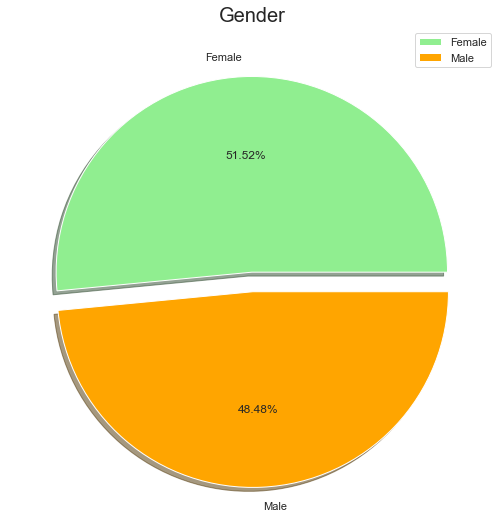

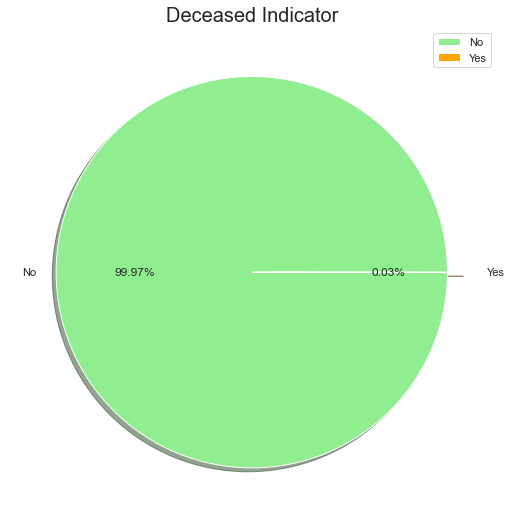

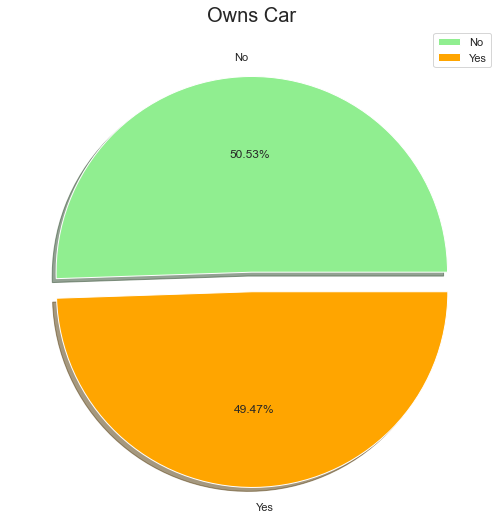

In [62]:
##########################################
# Data Visualization
# Gender
labels = ['Female', 'Male']
size = cd_normal['gender'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Gender', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# Descrease indicator
labels = ['No', 'Yes']
size = cd_normal['deceased_indicator'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Deceased Indicator', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()


# Owns car
labels = ['No', 'Yes']
size = cd_normal['owns_car'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Owns Car', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

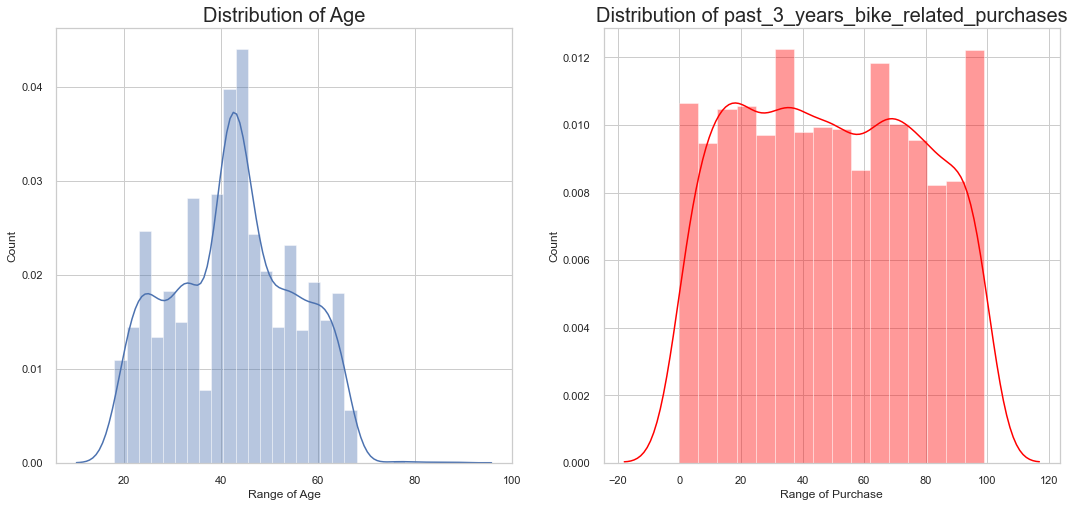

In [63]:
# Age and tenure

plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(cd_normal['age'])
plt.title('Distribution of Age', fontsize = 20)
plt.xlabel('Range of Age')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(cd_normal['past_3_years_bike_related_purchases'], color = 'red')
plt.title('Distribution of past_3_years_bike_related_purchases', fontsize = 20)
plt.xlabel('Range of Purchase')
plt.ylabel('Count')
plt.show()

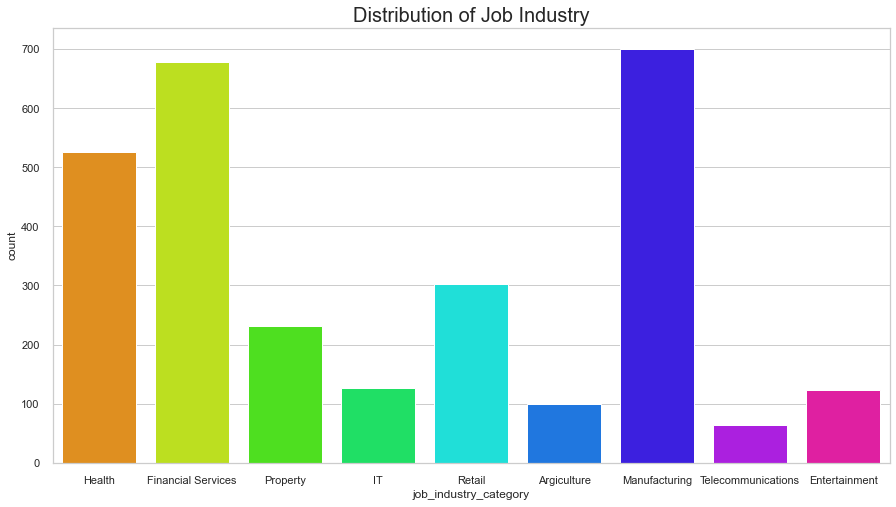

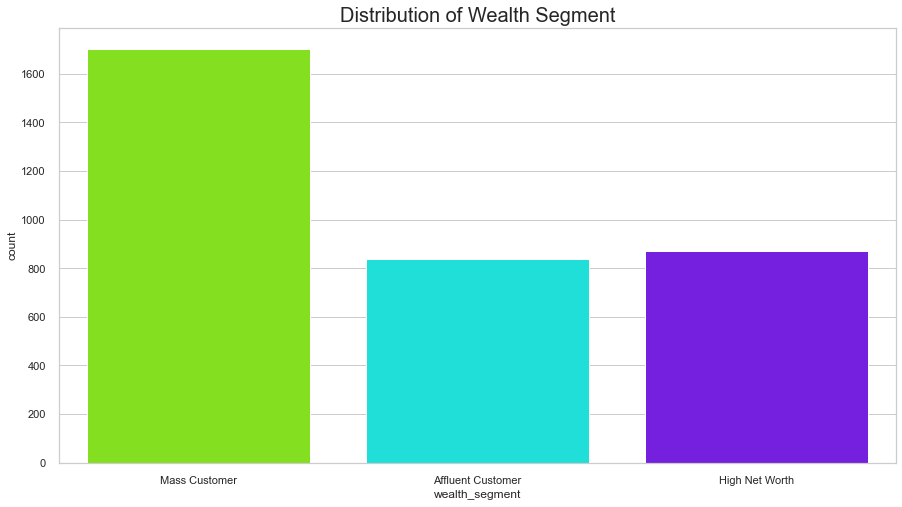

In [64]:
# job title and job industry

# Job title is too diversed to display
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(cd_normal['job_industry_category'], palette = 'hsv')
plt.title('Distribution of Job Industry', fontsize = 20)
plt.show()

# Wealth segment
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(cd_normal['wealth_segment'], palette = 'hsv')
plt.title('Distribution of Wealth Segment', fontsize = 20)
plt.show()

######### Finish the graphs for customer

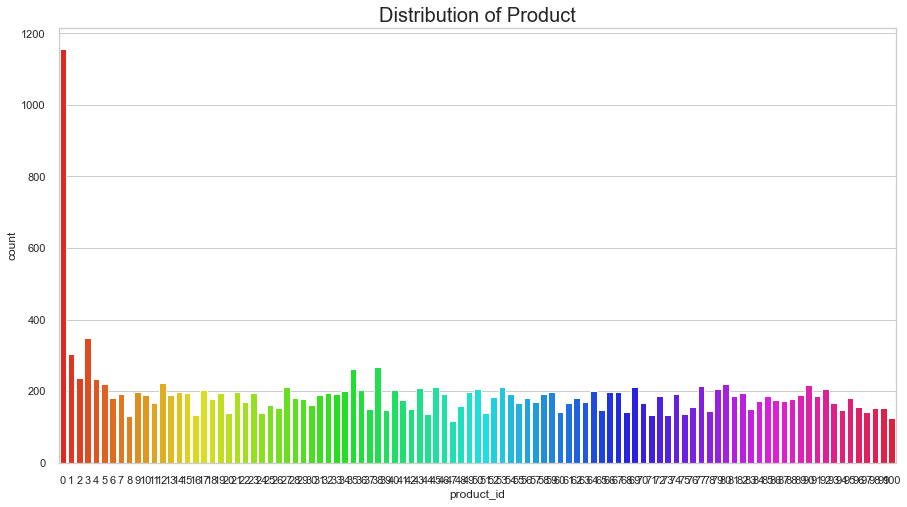

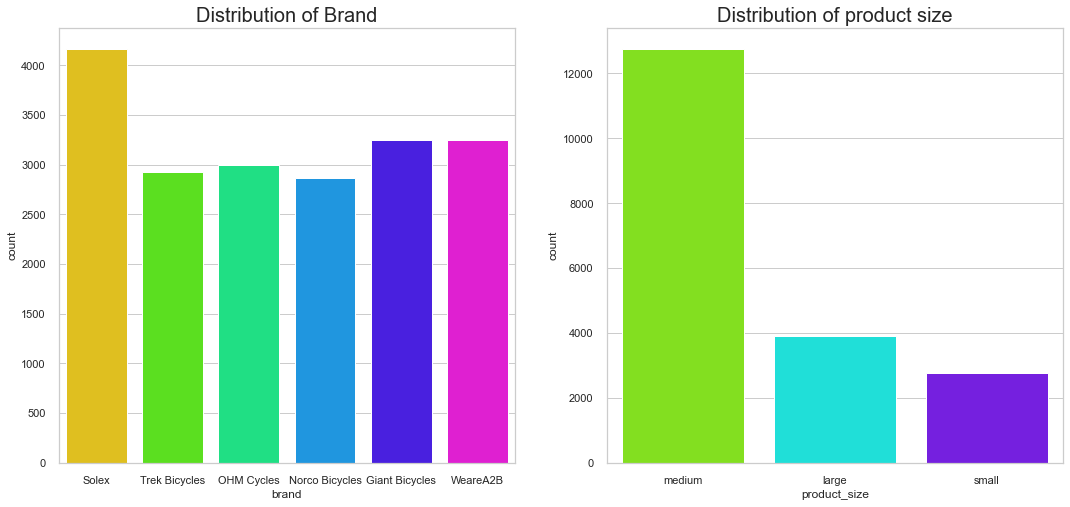

In [65]:
###### Starts the graphs for transactions
# Product id
plt.rcParams['figure.figsize'] = (15, 8)
sns.countplot(trans_dc['product_id'], palette = 'hsv')
plt.title('Distribution of Product', fontsize = 20)
plt.show()

# Customer is too diverse to show

plt.rcParams['figure.figsize'] = (18, 8)
# Brand
plt.subplot(1, 2, 1)
sns.countplot(trans_dc['brand'], palette = 'hsv')
plt.title('Distribution of Brand', fontsize = 20)

# Product size
plt.subplot(1, 2, 2)
sns.countplot(trans_dc['product_size'], palette = 'hsv')
plt.title('Distribution of product size', fontsize = 20)
plt.show()

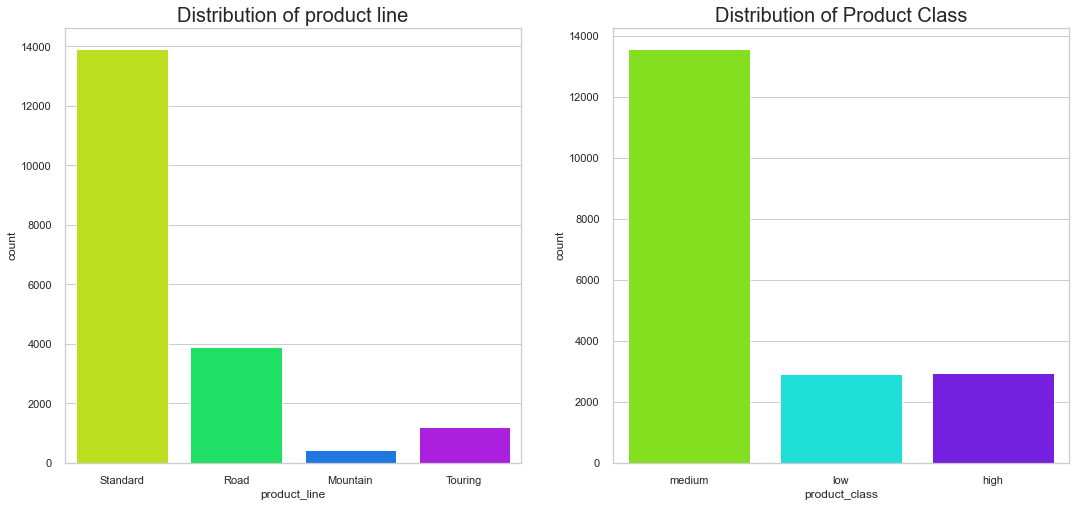

In [66]:
plt.rcParams['figure.figsize'] = (18, 8)

# Product line
plt.subplot(1, 2, 1)
sns.countplot(trans_dc['product_line'], palette = 'hsv')
plt.title('Distribution of product line', fontsize = 20)

# Product class
plt.subplot(1, 2, 2)
sns.countplot(trans_dc['product_class'], palette = 'hsv')
plt.title('Distribution of Product Class', fontsize = 20)
plt.show()

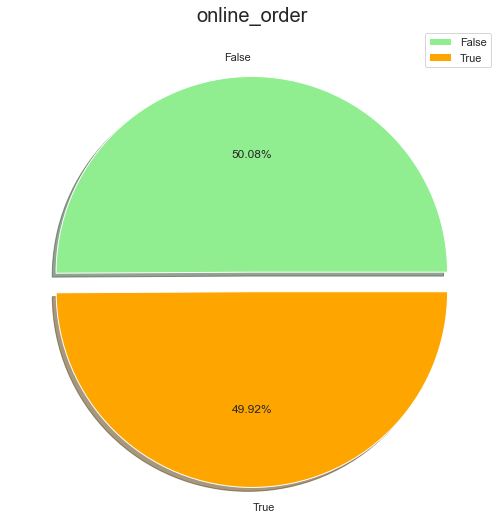

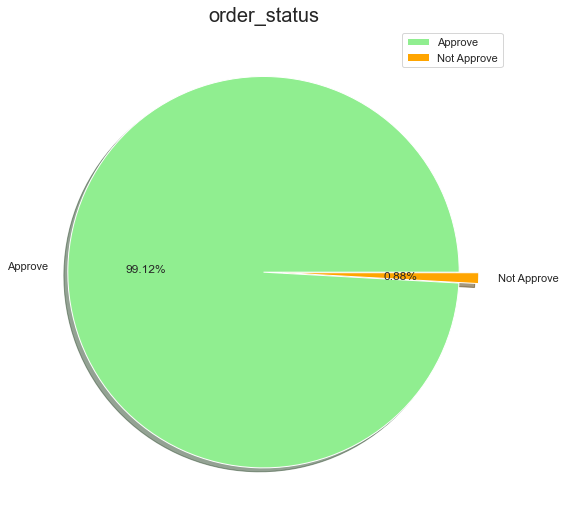

In [67]:
# Online order
labels = ['False', 'True']
size = trans_dc['online_order'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('online_order', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()

# order_status
labels = ['Approve', 'Not Approve']
size = trans_dc['order_status'].value_counts()
colors = ['lightgreen', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (9, 9)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('order_status', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show()



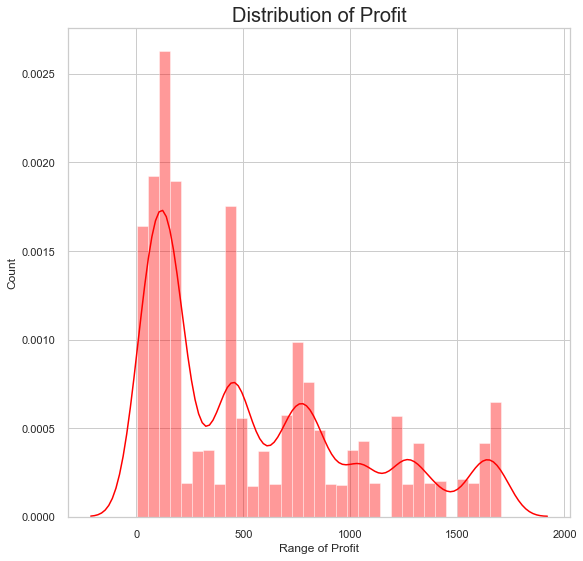

In [68]:
# Profit
sns.set(style = 'whitegrid')
sns.distplot(trans_dc['profit'], color = 'red')
plt.title('Distribution of Profit', fontsize = 20)
plt.xlabel('Range of Profit')
plt.ylabel('Count')
plt.show()
# Transaction graphs finish
############################

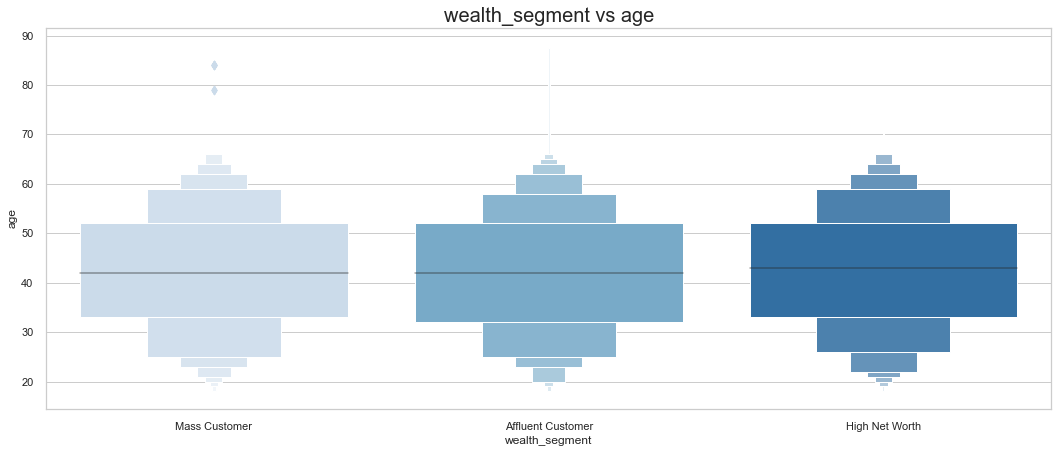

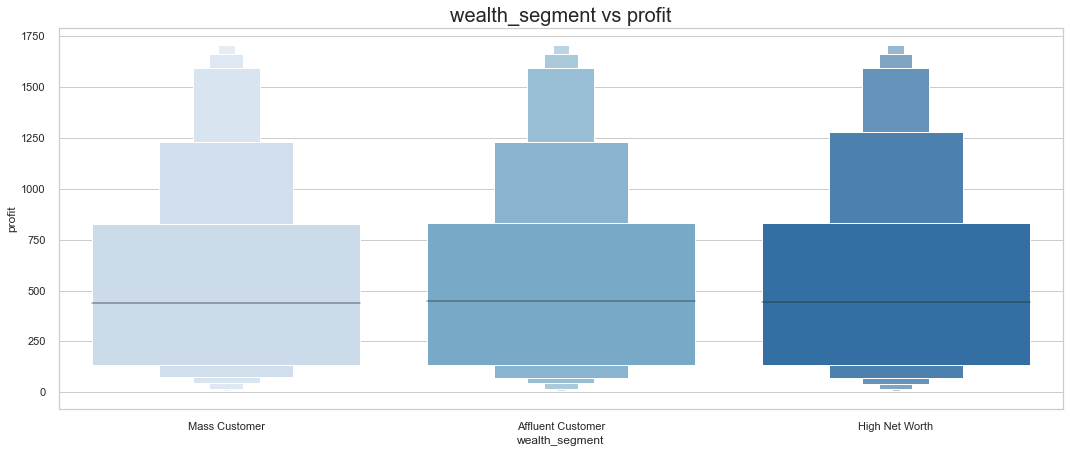

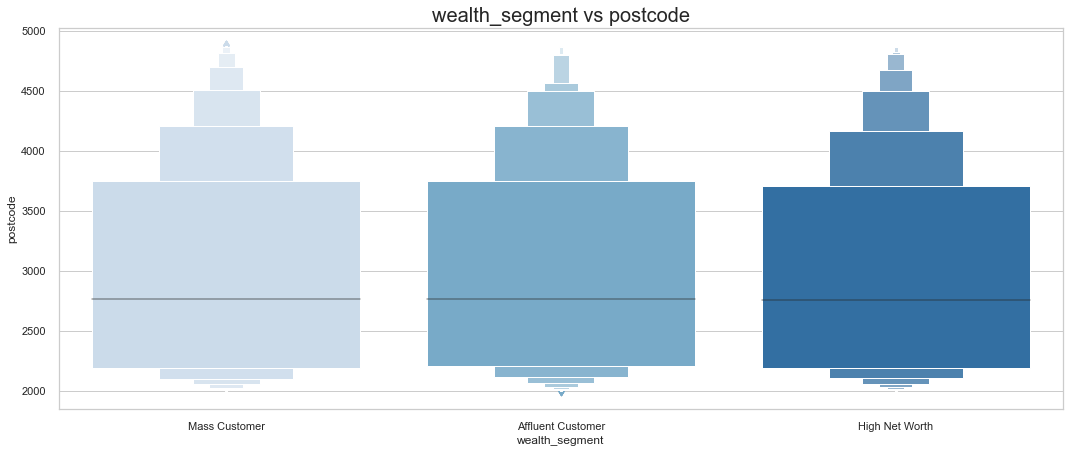

In [130]:
# Combined
# Wealth segment vs age
plt.rcParams['figure.figsize'] = (18, 7)
sns.boxenplot(cust_demo_addr_trans_no_ip['wealth_segment'], cust_demo_addr_trans_no_ip['age'], palette = 'Blues')
plt.title('wealth_segment vs age', fontsize = 20)
plt.show()
# Wealth segment vs profit
plt.rcParams['figure.figsize'] = (18, 7)
sns.boxenplot(cust_demo_addr_trans_no_ip['wealth_segment'], cust_demo_addr_trans_no_ip['profit'], palette = 'Blues')
plt.title('wealth_segment vs profit', fontsize = 20)
plt.show()
# Wealth segment vs postcode
plt.rcParams['figure.figsize'] = (18, 7)
sns.boxenplot(cust_demo_addr_trans_no_ip['wealth_segment'], cust_demo_addr_trans_no_ip['postcode'], palette = 'Blues')
plt.title('wealth_segment vs postcode', fontsize = 20)
plt.show()

In [137]:
#############################################################
#### Model build based on cd 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [143]:
df = cd_addr_normal.drop(['wealth_segment','country','address','state','first_name','last_name','customer_id'],axis = 1)
y = cd_addr_normal.wealth_segment
y = y.replace(2,0)
dy = {0:False,1:True}
y = y.map(dy)
# create training and testing vars
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.3)

In [144]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(2387, 10) (2387,)
(1023, 10) (1023,)


In [145]:
y_train.head()

3032    False
3122    False
1118    False
2087     True
1140    False
Name: wealth_segment, dtype: bool

In [154]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=50,min_samples_leaf = 10)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7478005865102639


In [155]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, df, y, cv=5)

In [156]:
scores

array([0.74486804, 0.74486804, 0.74486804, 0.74340176, 0.74340176])

gender = 0.030897594549246822
past_3_years_bike_related_purchases = 0.17971206250896826
job_title = 0.1803552548466766
job_industry_category = 0.06483848729536137
deceased_indicator = 0.0
owns_car = 0.02127822093919241
tenure = 0.11728491072849992
age = 0.1471794729450557
postcode = 0.1705803623354469
property_valuation = 0.08787363385155217


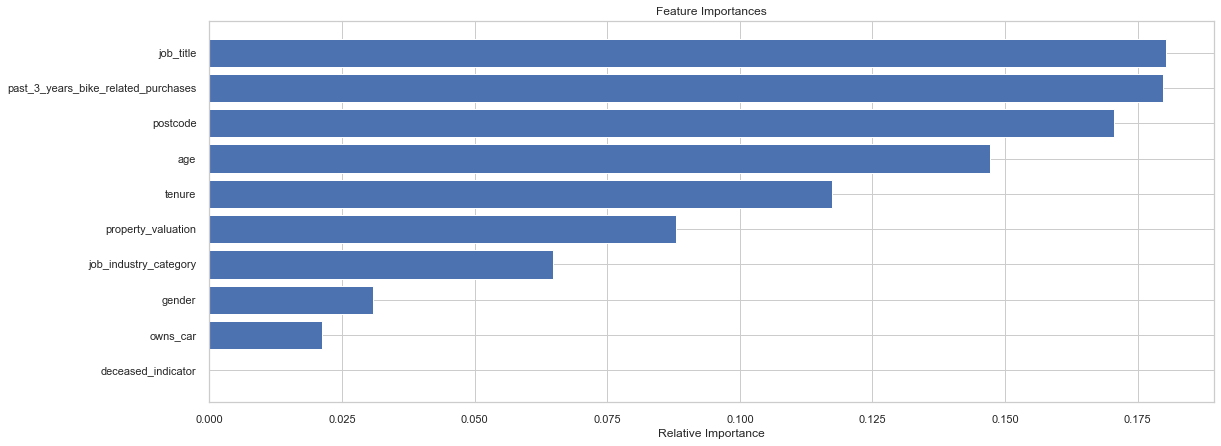

In [160]:
for name, importance in zip(list(df), clf.feature_importances_):
    print(name, "=", importance)
    
features = list(df)
importances = clf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

<AxesSubplot:xlabel='wealth_segment', ylabel='count'>

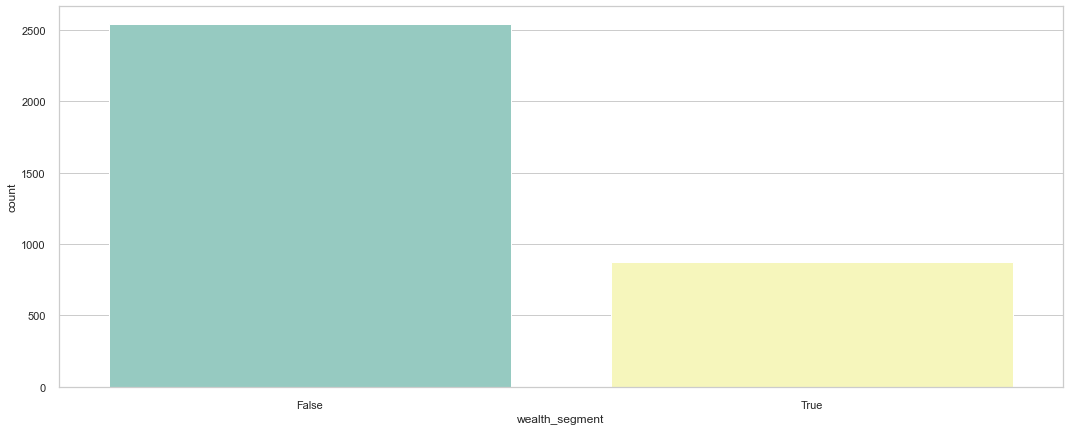

In [147]:
sns.countplot(y, palette='Set3')

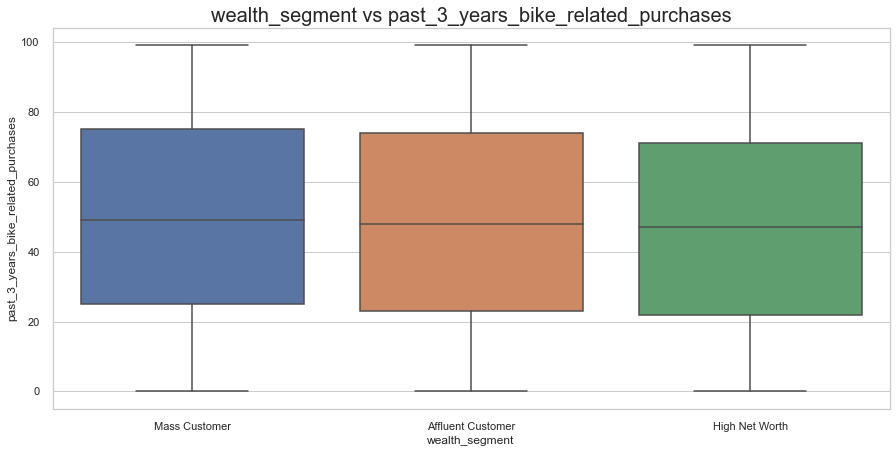

In [177]:
plt.rcParams['figure.figsize'] = (15, 7)
#sns.boxenplot(cust_demo_addr_trans_no_ip['wealth_segment'], cust_demo_addr_trans_no_ip['past_3_years_bike_related_purchases'], palette = 'Blues')
sns.boxplot(x=cust_demo_addr_no_ip['wealth_segment'], y=cust_demo_addr_no_ip['past_3_years_bike_related_purchases'])
plt.title('wealth_segment vs past_3_years_bike_related_purchases', fontsize = 20)
plt.show()



In [188]:
job_graph_only = cust_demo_addr_no_ip[["wealth_segment","job_title","customer_id"]]
#job_graph_only = job_graph_only.groupby(['wealth_segment',"job_title"]).count()
job_graph_only = job_graph_only.groupby(['wealth_segment',"job_title"])['customer_id'].agg(['count']).reset_index()
#job_graph_only.groupby(['wealth_segment',"job_title"])['customer_id'].agg( {'count':count()}).reset_index()
list(job_graph_only)

['wealth_segment', 'job_title', 'count']

In [203]:
job_graph_only[job_graph_only["wealth_segment"] == "High Net Worth"].sort_values(by ='count' , ascending=False)[0:5]

,wealth_segment,job_title,count
231,High Net Worth,Dental Hygienist,14
225,High Net Worth,Cost Accountant,13
318,High Net Worth,Senior Developer,12
353,High Net Worth,VP Product Management,12
240,High Net Worth,Electrical Engineer,12


In [204]:
job_graph_only[job_graph_only["wealth_segment"] == "Affluent Customer"].sort_values(by ='count' , ascending=False)[0:5]

,wealth_segment,job_title,count
35,Affluent Customer,Business Systems Development Analyst,24
171,Affluent Customer,VP Sales,13
70,Affluent Customer,General Manager,13
142,Affluent Customer,Social Worker,12
123,Affluent Customer,Recruiting Manager,12


In [205]:
job_graph_only[job_graph_only["wealth_segment"] == "Mass Customer"].sort_values(by ='count' , ascending=False)[0:5]

,wealth_segment,job_title,count
536,Mass Customer,Tax Accountant,25
446,Mass Customer,Help Desk Technician,24
510,Mass Customer,Social Worker,22
401,Mass Customer,Chemical Engineer,22
490,Mass Customer,Recruiting Manager,22


In [189]:
jt = job_graph_only["job_title"].drop_duplicates()[0:5]

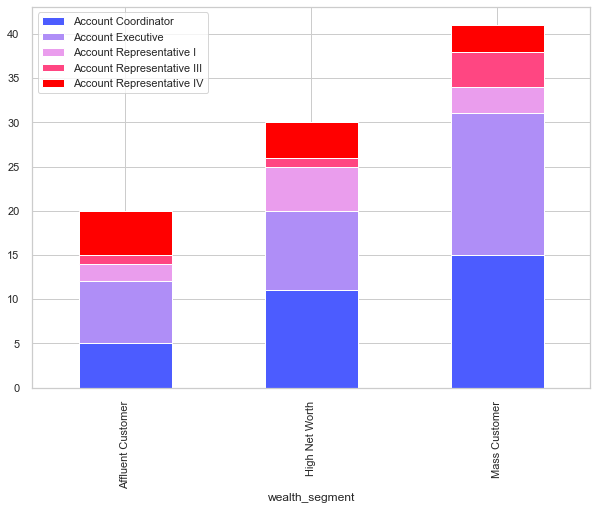

In [192]:
fig, ax = plt.subplots(figsize=(10,7))  

jt = ["Dental Hygienist","Cost Accountant","Senior Developer","VP Product Management","Electrical Engineer",\
      "Staff Accountant I","Research Assistant III","Geologist III","Accountant III	","Geologist IV	"]
margin_bottom = np.zeros(len(job_graph_only["wealth_segment"].drop_duplicates()))
colors = ["#4c5cff", "#af8ef7","#ea9ded","#ff4682","#ff0000"]

for num, job in enumerate(jt):
    values = list(job_graph_only[job_graph_only['job_title'] == job].loc[:, 'count'])

    job_graph_only[job_graph_only['job_title'] == job].plot.bar(x='wealth_segment',y='count', ax=ax, stacked=True, 
                                    bottom = margin_bottom, color=colors[num], label=job)
    margin_bottom += values

plt.show()